# Mini Project 1

# Synthetic Magnetic Field Data for Estimating Translational forces Danger zones in an MRI


*Author: Daniel Juarez*

## Introduction

There is a concern on whether a patient with a retained post-surgical epicardial leads can safely be scanned in an MRI scanner because of the interactions of the magnetic field, radiofrequency (RF) and gradients with these leads are not well defined. Accurately reconstructing the static magnetic field may be useful to assess whether an object might move near the scanner during the test. Real measurements are hard to collect, scheduling use-time of these scanners on the clinic is limited due to the high demand on patients, moreover we are limited to measurements of the magnetic field in a sigle point at a time to estimate gradients on it, also noise and uncertainty can obscure the true field.

In this notebook, our goal is to simulate:

> **How and where translational forces arise from static magnetic field gradients for a range of paramagnetic materials**

We use python to simulate a solenoid magnetic field in the z-axis only as a ideal case then compute dBdz and introduce synthetic noise to mimic real-world uncertainty. We will explore susceptibility of materials as well as Translational Forces due to the interaction with a Static Magnetic Field. Then we will repeat the experiment with different uncertainties simulating measurments and find where the maximum force happens. 

---

### Assupmtions

- The lead is small, passive and fixed in the field
- Force acts on the center of mass (translational forces only)
- Orientation and torque not modeled
- Susceptibility is assumed constant per material and averaged for composites
- Density is derived form size and mass. (as in the lab can measure those)

## Magnetic Susceptibility

Objects are attracted to magnetic fields in different strength depending on its suceptibility $\chi$, and are divided intro 3 main groups, 

- Diamagnetic:  −1.0 < χ < 0
- Paramagnetic: χ > 0
    - "nonmagnetic": |χ| < approximately 0.01
    - Ferromagnetic: |χ| > approximately 0.01

χ values less than −1.0 are not possible.

A good categorization figure is as follows

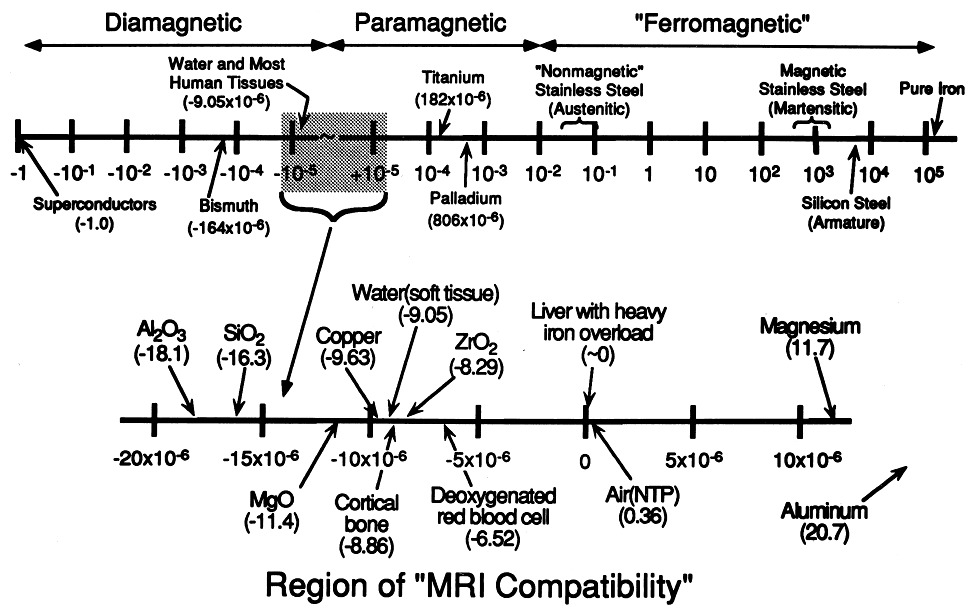

This attraction does not behave in the intuitve way we might expect. One might assume that the closer an object gets to the center the stronger the force it feels, however the opposite is true, at the center of the bore, the magnetic field is very strong but also uniform, that is its gradient is near zero and results in almost no translational force. We are going to verify just that.


## Magnetic Field of a Finite Solenoid

The magnetic field at point $ z $ (along the solenoid axis) is given by Biot-Savart law: 

$$
B(z) = \frac{\mu_0 n I}{2} \left( \frac{z + L/2}{\sqrt{R^2 + (z+ L/2)^2}} - \frac{z- L/2}{\sqrt{R^2 + (z- L/2)^2}} \right)
$$

Where:
- $\mu_0$ is the vacuum permeability

- $n$ is the number of turns per unit length

- $I$ is the current through the solenoid

- $R$ is the radius of the solenoid

- $L$ is the solenoid length

- $z$ is the axial position relative to the center of the solenoid


We want this equation to be normalized so it produces a peak field of 3 tesla to be representative of a powerful clinial MRI, that is we will work with $B0=\frac{\mu_0 n I}{2}=3 \text{Tesla}$.

We start by importing the required libraries, in our case it would be numpy, matplotlib and scipy.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import mu_0 as mu0

Now we can define our $B(z)$ function that will depend on a B0 constant, the size of the magnet and will run on the z axis

In [2]:
def Bz(z, R, L, B0):
    '''
    Biot-Savart Law for a static magnetic field
    Takes:
        z: coordinate along the length of a solenoid
        R: radius of the solenoid
        L: length of the solenoid
        B0: magnetic field constant at its center
    Returns
    B(z)
    '''
    z1 = z - L / 2
    z2 = z + L / 2
    profile = (z2 / np.sqrt(R**2 + z2**2)) - (z1 / np.sqrt(R**2 + z1**2))
    profile_center = (L/2) / np.sqrt(R**2 + (L/2)**2) * 2  # max value at z=0
    return B0 * (profile / profile_center)

Then we try our function with the parameters below, we chose this values in order to better approximate a real MRI scanner

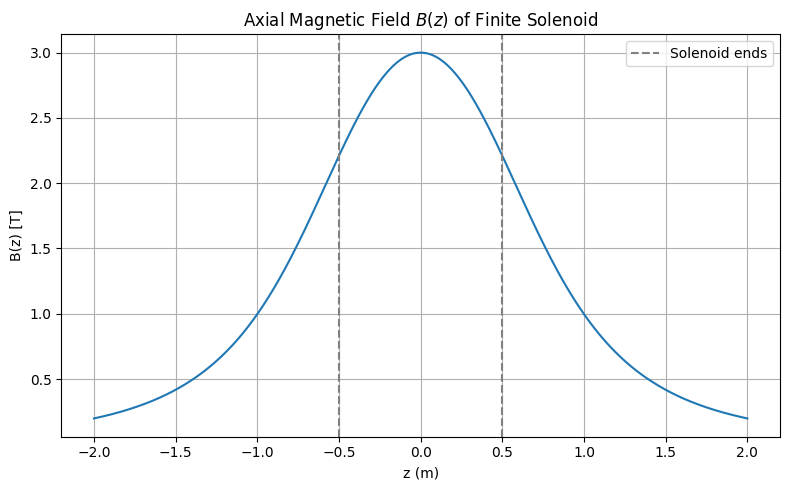

In [3]:
R=0.8; L=1.0; B0=3.0

# Generate B(z) over a range of z
z_vals = np.linspace(-2, 2, 500)  # meters
B_vals = Bz(z_vals,R,L,B0)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(z_vals, B_vals)
plt.title("Axial Magnetic Field $B(z)$ of Finite Solenoid")
plt.xlabel("z (m)")
plt.ylabel("B(z) [T]")
plt.grid(True)
plt.axvline(-L/2, color='gray', linestyle='--', label='Solenoid ends')
plt.axvline( L/2, color='gray', linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()

Once we have a magnetic field we need to calculate the spatial gradient of it.

We then numerically compute the spatial gradient $\frac{dB}{dz}$ using finite differences. 

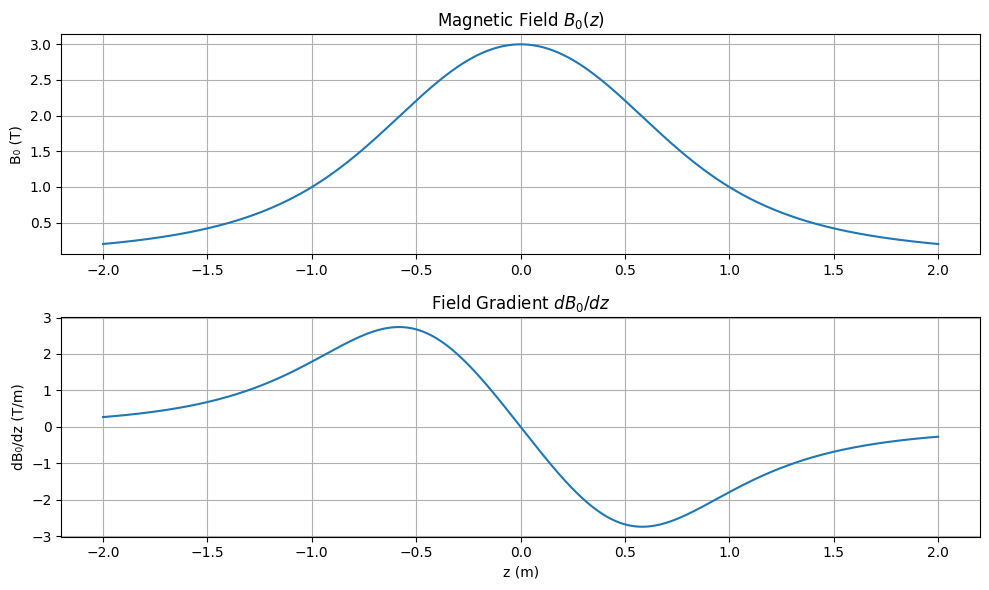

In [4]:
# Numerical derivative of B(z) with respect to z
dB_dz = np.gradient(B_vals, z_vals)  # dB/dz

# Plot B(z) and dB/dz together
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(z_vals, B_vals)
plt.title("Magnetic Field $B_0(z)$")
plt.ylabel("B₀ (T)")
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(z_vals, dB_dz)
plt.title("Field Gradient $dB_0/dz$")
plt.xlabel("z (m)")
plt.ylabel("dB₀/dz (T/m)")
plt.grid(True)

plt.tight_layout()
plt.show()


## Translational Force in Static Magnetic Fields

Here we can clearly see the nature of the gradients in this ideal solenoid.
At $z = 0.0$ we got 0 gradient. Then the translational magnetic force arises from the interaction between the object's magnetization and the spatial gradient of the magnetic field. In a simplified case, the force is proportional to the product of the local field $B$ and its spatial derivative:

$$
F_{trans} \propto \chi B(z) \frac{dB}{dz}
$$

This is why the strongest pull occurs not at the center, but just outside the the scanner bore, where the magnetic field rapidly increases. That is the reason of the delimited MRI safe zones. MRI scanners with active shielding tend to compress this transition into a smaller zone and that leads to even bigger gradients.

Studies on this have shown the way to analyze this fields. We define danger as the point where the magnetic force excceds gravity:

$$
\frac{F_{mag}}{F_{g}} > 1
$$

And this gives us an somewhat intuitive scale when something may experience enough force to become a projectile.

Following the simulation, we want to add some gaussian noise to our magnetic field and gradient in order to better capture the nature of real-world field measurements. Then we analyze how this affects force predictions.

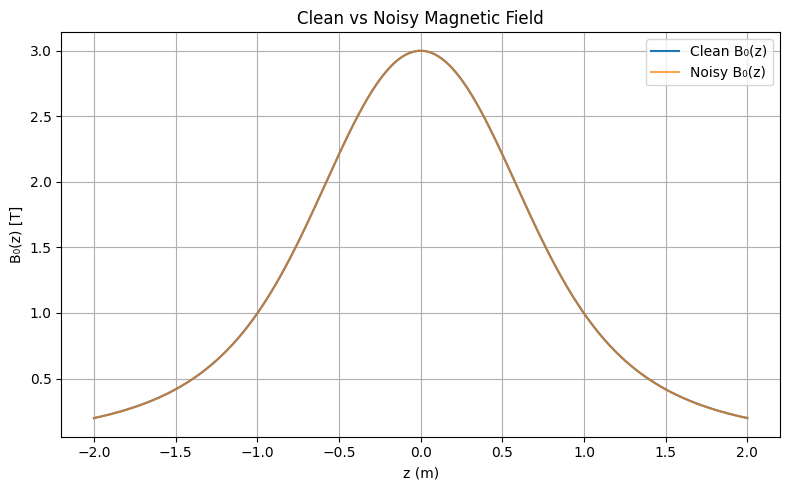

In [6]:
# Set random seed for reproducibility
np.random.seed(abs(hash("magnetism rules")) % (2**32))

# Choose standard deviation of noise (e.g., 1 mT)
noise_std = 1e-3  # in Tesla

# Add Gaussian noise to magnetic field
B_noisy = B_vals + np.random.normal(loc=0, scale=noise_std, size=B_vals.shape)

# Plot: clean vs noisy
plt.figure(figsize=(8, 5))
plt.plot(z_vals, B_vals, label='Clean B₀(z)')
plt.plot(z_vals, B_noisy, label='Noisy B₀(z)', alpha=0.7)
plt.title("Clean vs Noisy Magnetic Field")
plt.xlabel("z (m)")
plt.ylabel("B₀(z) [T]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


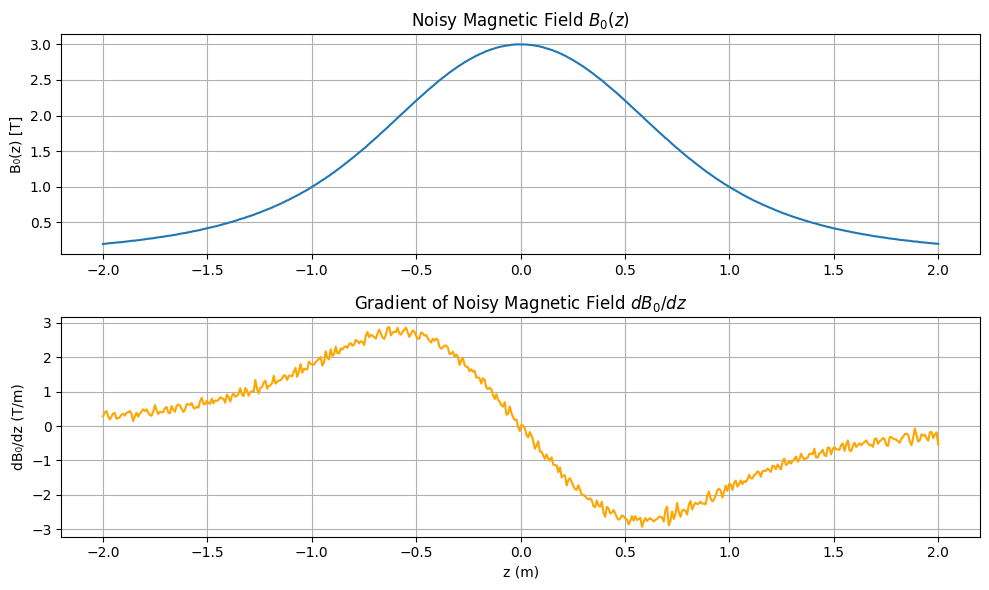

In [7]:
# Compute gradient of noisy magnetic field
dB_noisy_dz = np.gradient(B_noisy, z_vals)

# Plot: noisy field and its gradient
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(z_vals, B_noisy, label='Noisy B₀(z)')
plt.title("Noisy Magnetic Field $B_0(z)$")
plt.ylabel("B₀(z) [T]")
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(z_vals, dB_noisy_dz, color='orange', label='dB₀/dz (noisy)')
plt.title("Gradient of Noisy Magnetic Field $dB_0/dz$")
plt.xlabel("z (m)")
plt.ylabel("dB₀/dz (T/m)")
plt.grid(True)

plt.tight_layout()
plt.show()


### Translational Forces simulation 

We define the physical properties of a cylindrical lead 
lenght = 5cm 
diameter = 1mm
mass = 114 mg

For this we assumed, that the object is an abandoned or retained epicardial lead fragment, cut or left behind.
mass of a composites of materials, considering a metal core (MP35N or molybdenum wires) and insulation layer (silicione, polyurethane, PTFE/ETFE.

Then we compute its density, and evaluate translational force for a range of suceptibilities from $10^{-5}$ (non-magnetic) to  $10^{-1}$ (weakly ferromagnetic).
Range that we decided upon on the following table:


| Material               | Notes                                       | Estimated \( \chi \)         |
|------------------------|---------------------------------------------|-------------------------------|
| Molybdenum             | Paramagnetic; used in temporary wires       | $\sim 1.2 \times 10^{-4} $ |
| MP35N Alloy            | Weakly ferromagnetic                        | $ \sim 10^{-3} $ to $ 10^{-2} $ |
| Zr-based Alloys        | MRI-compatible implant metals               | $ \sim 10^{-5} $ to $ 10^{-4} $ |
| Titanium Alloys        | Used in medical implants                    | $ \sim 1.8 \times 10^{-4} $ |
| Stainless Steel (316L) | Slightly magnetic if cold-worked            | up to $ 10^{-2} $           |
| Platinum-Iridium       | Diamagnetic or near-zero susceptibility     | $ \approx 0 $               |



We plot the force to weight ratio vs $z$. If the ratio of forces is bigger than 1 we can draw a danger zone.

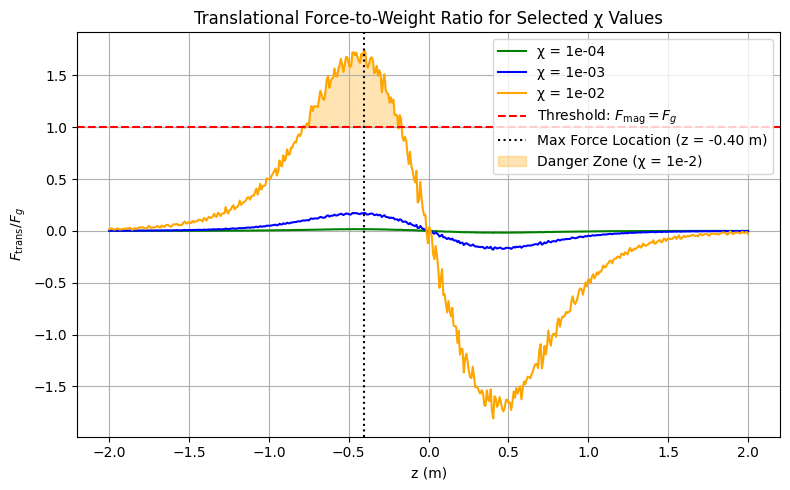

In [8]:
# Physical constants and object parameters
# Function to calculate volume and mass of a cylindrical object
def calc_lead_properties(length_m, diameter_m, mass):
    """
    Calculates volume and mass of a cylindrical lead.
    
    Parameters:
        length_m (float): Length in meters
        diameter_m (float): Diameter in meters
        density_kg_m3 (float): Material density (default = 8000 for stainless steel)
        
    Returns:
        volume (float): Volume in m³
        mass (float): Mass in kg
    """
    radius = diameter_m / 2
    volume = np.pi * radius**2 * length_m
    density_kg_m3 = mass / volume
    return volume, density_kg_m3


# Example: 5 cm long, 1 mm diameter lead
lead_length = 0.05       # meters (5 cm)
lead_diameter = 0.001    # meters (1 mm)
mass = 0.000114          # kg (114 mg)

_ , rho = calc_lead_properties(lead_length, lead_diameter,mass)


g = 9.81

C = 1 / (mu0 * g * rho) #our proportional constant

chi_values = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]  # fist one is barely MRI compatible, last two are weakly ferromagnetic

force_ratios = {}

B_field=B_noisy
dBdz=dB_noisy_dz

# Loop and compute all
for chi in chi_values:
    F_trans_g = chi * C * (B_field * dBdz)
    force_ratios[chi] = F_trans_g  # Store it

# Now plot only some of χ
highlight_chis = [1e-4, 1e-3, 1e-2]

# to draw a max value in z
z_at_max = z_vals[np.argmax(force_ratios[1e-2])]

plt.figure(figsize=(8, 5))

# Plot each selected chi
colors = ['green', 'blue', 'orange']
for chi, color in zip(highlight_chis, colors):
    F_plot = force_ratios[chi]
    plt.plot(z_vals, F_plot, label=f'χ = {chi:.0e}', color=color)

# Add threshold line
plt.axhline(1, color='red', linestyle='--', label='Threshold: $F_{\\text{mag}} = F_g$')
plt.axvline(z_at_max, color='black', linestyle=':', label=f'Max Force Location (z = {z_at_max:.2f} m)')

# Highlight danger zone for χ = 1e-2 (only if it exists)
F_danger = force_ratios[1e-2]
danger_zone = F_danger > 1
if np.any(danger_zone):
    plt.fill_between(z_vals, F_danger, 1, where=danger_zone, color='orange', alpha=0.3, label='Danger Zone (χ = 1e-2)')

plt.title("Translational Force-to-Weight Ratio for Selected χ Values")
plt.xlabel("z (m)")
plt.ylabel("$F_{\\text{trans}} / F_g$")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
print(f"{'χ':>5} | {'Avg Force (F/Fg)[N]':>18} | {'Max Force (F/Fg)[N]':>18}")
print("-" * 50)

for chi in chi_values:
    F = force_ratios[chi]

    mask = F > 1
    avg = np.mean(F[mask]) if np.any(mask) else 0

    max_force = np.max(F)

    marker = " <== Graph" if chi in highlight_chis else ""
    print(f"{chi:>5.0e} | {avg:19.2f} | {max_force:19.3f}{marker}")


    χ | Avg Force (F/Fg)[N] | Max Force (F/Fg)[N]
--------------------------------------------------
1e-05 |                0.00 |               0.002
1e-04 |                0.00 |               0.017 <== Graph
1e-03 |                0.00 |               0.174 <== Graph
1e-02 |                1.43 |               1.739 <== Graph
1e-01 |                8.69 |              17.388


This table helps summarize how quickly translational forces increases with incresing susceptibility.
At non-magenetic materials force is negligible, at $10^2$ force is strong enought to exceed gravity and theres a risk, this is also the expected suceptibility for an epicardial lead, beyond this point is unsafe. which aligns with the given clasification above.

### Noise Propagation and Max Force Estimation

We repeat the force simulation 1000 times, each with newly sampled noise. For each run, we record the maximum translational force and its position. The histogram of peak locations shows two consistent danger zones centered at:

- $z = -0.43$ m

- $z = -0.47$ m

These locations correspond to the region just outside the bore, where the field gradient is strongest. The mean and standard deviation of force values in these regions are reported.

To verify whether this double-peak behavior is an artifact of lead size, we repeat the simulation for shorter and longer leads (1 cm and 10 cm). The force peak positions remain unchanged, confirming that this behavior is driven by the magnetic field profile and not the object geometry.

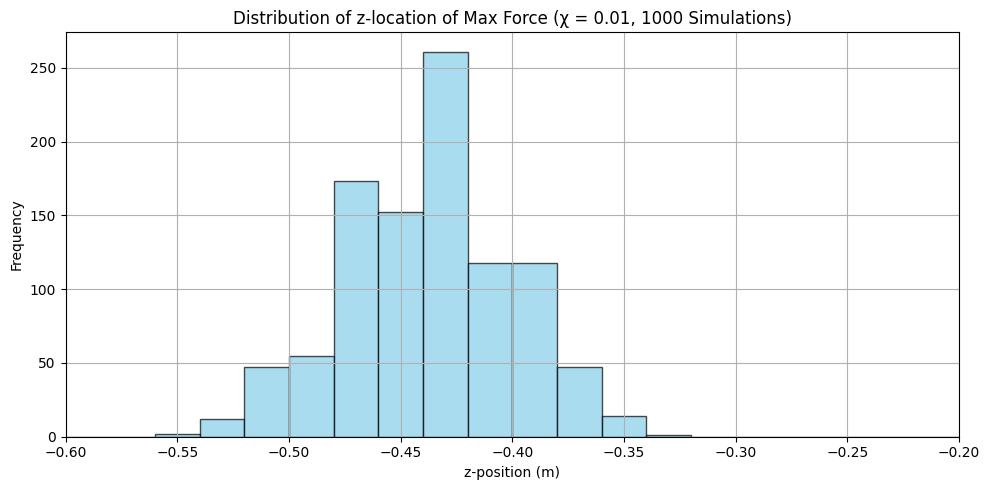

Max Force-to-Weight Ratio over 1000 simulations:

🔵 Primary Peak
  z-position   [m]: -0.430
  Mean         [N]: 1.784·F_g
  Std Dev      [N]: 0.030·F_g
  Maximum      [N]: 1.892·F_g

🟢 Secondary Peak
  z-position   [m]: -0.470
  Mean         [N]: 1.779·F_g
  Std Dev      [N]: 0.032·F_g
  Maximum      [N]: 1.914·F_g


In [10]:
from scipy.signal import find_peaks
num_trials = 1000
chi = 1e-2

# Simulation

max_force_ratios = []
max_force_positions = []

for _ in range(num_trials):
    B_noisy = B_vals + np.random.normal(0, noise_std, size=B_vals.shape)
    dB_noisy = np.gradient(B_noisy, z_vals)
    F_trans_g = chi * C * (B_noisy * dB_noisy)
    
    max_idx = np.argmax(F_trans_g)
    max_force_ratios.append(F_trans_g[max_idx])
    max_force_positions.append(z_vals[max_idx])

# Convert to arrays
max_force_ratios = np.array(max_force_ratios)
max_force_positions = np.array(max_force_positions)

# Histogram for peak detection and plotting
hist_counts, bin_edges = np.histogram(max_force_positions, bins=20, range=(-0.6, -0.2))
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# Plot the histogram
plt.figure(figsize=(10, 5))
plt.hist(max_force_positions, bins=20, range=(-0.6, -0.2), color='skyblue', edgecolor='black', alpha=0.7, label='Histogram')
plt.xlim(-0.6, -0.2)
plt.title(f"Distribution of z-location of Max Force (χ = {chi}, {num_trials} Simulations)")
plt.xlabel("z-position (m)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# Peak detection
from scipy.signal import find_peaks
peaks, _ = find_peaks(hist_counts, distance=2)

# Sort peaks by frequency
sorted_indices = np.argsort(hist_counts[peaks])[::-1]

# Summary if we have 2 peaks
if len(sorted_indices) >= 2:
    peak1_idx = peaks[sorted_indices[0]]
    peak2_idx = peaks[sorted_indices[1]]

    z1 = bin_centers[peak1_idx]
    z2 = bin_centers[peak2_idx]

    # Bin edges for masks
    bin1_start = bin_edges[peak1_idx]
    bin1_end = bin_edges[peak1_idx + 1]
    bin2_start = bin_edges[peak2_idx]
    bin2_end = bin_edges[peak2_idx + 1]

    # Accurate masks using bin edges
    mask1 = (max_force_positions >= bin1_start) & (max_force_positions < bin1_end)
    mask2 = (max_force_positions >= bin2_start) & (max_force_positions < bin2_end)

    # Stats
    mean1 = np.mean(max_force_ratios[mask1])
    std1 = np.std(max_force_ratios[mask1])
    max1 = np.max(max_force_ratios[mask1])

    mean2 = np.mean(max_force_ratios[mask2])
    std2 = np.std(max_force_ratios[mask2])
    max2 = np.max(max_force_ratios[mask2])

print(f"Max Force-to-Weight Ratio over {num_trials} simulations:\n")

print("🔵 Primary Peak")
print(f"  z-position   [m]: {z1:.3f}")
print(f"  Mean         [N]: {mean1:.3f}·F_g")
print(f"  Std Dev      [N]: {std1:.3f}·F_g")
print(f"  Maximum      [N]: {max1:.3f}·F_g\n")

print("🟢 Secondary Peak")
print(f"  z-position   [m]: {z2:.3f}")
print(f"  Mean         [N]: {mean2:.3f}·F_g")
print(f"  Std Dev      [N]: {std2:.3f}·F_g")
print(f"  Maximum      [N]: {max2:.3f}·F_g")



In [11]:
(z1 - z2) / lead_length

np.float64(0.7999999999999985)

## Conclusion

In this project I wanted to understand what kind of translational forces might arise on small metallic objects, specifically retained epicardial leads, when placed in the static magnetic field of an MRI scanner. I used a normalized solenoid field model targeting 3T, which is at the upper range of clinical MRI systems. These scanners are large and powerful, and even though 1.5T is more common in practice, 3T is where we might expect worst-case behavior.

Something that stood out early was that the strongest forces weren’t at the center of the bore, where the field is strongest, but just outside of it, where the field changes fastest. This simulation confirmed an interesting and initially nonintuitive fact: objects experience translational force where the field gradient is steep, not where the field is strongest. Now I can even see it coming from the inflection point in the field gradient curve.

I wanted to understand whether the danger zone was consistent, and ran the simulation many times with noise added. What I found was that two very consistent force peaks emerged at fixed positions (around z = -0.43 and z = -0.47). I was curious if this was an artifact of lead length, so I varied the size and saw that the peaks remained unchanged. That told me the danger zones were a property of the field, not the object.

This also helped me think more clearly about the experimental data I’m working on in another notebook, where I’m fitting susceptibility values based on real measurements. The simulation gave me intuition: it let me understand what those measurements are sensitive to and how uncertainty might affect them.

One idea that came up was whether two force peaks across the length of the object might produce torque or internal deformation. For now, I modeled the lead as a point, but this naturally leads to future extensions: modeling torque, tilts, or a full 3D force field. In fact, I even started to explore that by building a 3D version of the solenoid field and plotting a top-down vector field—something I might come back to later.

Overall, this helped me test my assumptions, verify the physics, and build a useful baseline for thinking about real-world safety in MRI.

## References

1. Hendee, W. R., & Cross, A. P. (2001). *MRI Safety: Static Magnetic Fields*. Journal of Magnetic Resonance Imaging, 12(1), 2–19. https://onlinelibrary.wiley.com/doi/10.1002/jmri.25761  
2. Shellock, F. G., & Kanal, E. (2000). *Magnetic Resonance: Bioeffects, Safety, and Patient Management*. Journal of Magnetic Resonance Imaging, 12(1), 2–19. https://onlinelibrary.wiley.com/doi/full/10.1002/1522-2586(200007)12:1%3C2::AID-JMRI2%3E3.0.CO;2-V  
3. How to Pace. *Basics of Pacing Leads*. Retrieved from https://www.howtopace.com/basics-of-pacing-leads/  
4. European Heart Journal Supplements. *Innovative Epicardial Lead Designs for Pediatric Use*. https://academic.oup.com/eurheartj/article/45/Supplement_1/ehae666.738/7838314  
5. Rahman, M., et al. (2016). *Magnetic field interactions and heating of implants during MRI*. Chest, https://www.sciencedirect.com/science/article/abs/pii/S0012369216414200  
6. MDPI Journal of Clinical Medicine. *MRI Safety of Cardiac Devices*. https://www.mdpi.com/2077-0383/12/18/5766
